In [1]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/home/gonzalo/Downloads/ml4cc-general-access_request_pays.json"
os.environ["GS_USER_PROJECT"] = "ml4cc-general"

In [2]:
from ml4floods.data import utils
from ml4floods.visualization import plot_utils

path_to_aois = "gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/"
fs = utils.get_filesystem(path_to_aois)

[Flooding period according to Wikipedia](https://en.wikipedia.org/wiki/2022_Eastern_Australia_floods): 23 February 2022 – 7 April 2022

We divide this period in:
* Flooding period first flood 23rd Feb to 27th March
* Flooding period second flood 28th March 10th April


In [3]:
from datetime import datetime, timedelta

flooding_date_pre = "2022-02-20"
flooding_date_pre_dt =datetime.strptime(flooding_date_pre, "%Y-%m-%d")
flooding_date_first_period_start= "2022-02-23"
flooding_date_first_period_end = "2022-03-27"
flooding_date_first_period_start_dt =datetime.strptime(flooding_date_first_period_start, "%Y-%m-%d")
flooding_date_first_period_end_dt =datetime.strptime(flooding_date_first_period_end, "%Y-%m-%d")

flooding_date_second_period_start = "2022-03-28"
flooding_date_second_period_end = "2022-04-10"
flooding_date_second_period_start_dt = datetime.strptime(flooding_date_second_period_start, "%Y-%m-%d")
flooding_date_second_period_end_dt = datetime.strptime(flooding_date_second_period_end, "%Y-%m-%d")

## Step 1: Grab all the predicted floodmaps for a given Area of Interest

In [4]:
# Grab all predictions for a given AOI

# aoi = "AOI02" # Lismore AoI

aoi = "QLAOI03" # Cabolture AoI (images out of swath, clouds etc)
# aoi = "QLAOI07"
aoi = "AUTOAOI144"

geojsons = [f"gs://{f}" for f in fs.glob(f"{path_to_aois}{aoi}/WF2_unet_rbgiswirs_vec/*/*.geojson")]

# Sort by date (name of the file) and satellite 
def key_sort(x):
    date = os.path.splitext(os.path.basename(x))[0]
    satellite = os.path.basename(os.path.dirname(x))
    # Preference of Sentinel over Landsat
    if satellite == "Landsat":
        append = "B"
    else:
        append = "A"
    return date+append

geojsons.sort(key=key_sort)
geojsons

['gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/S2/2022-02-13.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/Landsat/2022-02-14.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/S2/2022-03-10.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/Landsat/2022-03-10.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/S2/2022-03-20.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/S2/2022-03-25.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/Landsat/2022-03-26.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/S2/2022-03-30.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operationa

## Plot mean cloud coverage of available S2 and Landsat images

We have downloaded all images which have less than 60% of clouds

In [5]:
from ml4floods.data.ee_download import process_metadata
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from math import ceil


metadata_s2 = process_metadata(f"{path_to_aois}{aoi}/S2/s2info.csv")
metadata_l89 = process_metadata(f"{path_to_aois}{aoi}/Landsat/landsatinfo.csv")

metadata_s2["satellite"] = "S2"
metadata_l89["satellite"] = "Landsat"
metadata = pd.concat([metadata_s2, metadata_l89],ignore_index=True)
metadata.cloud_probability*=100
metadata = metadata[metadata["valids"] >= .8]

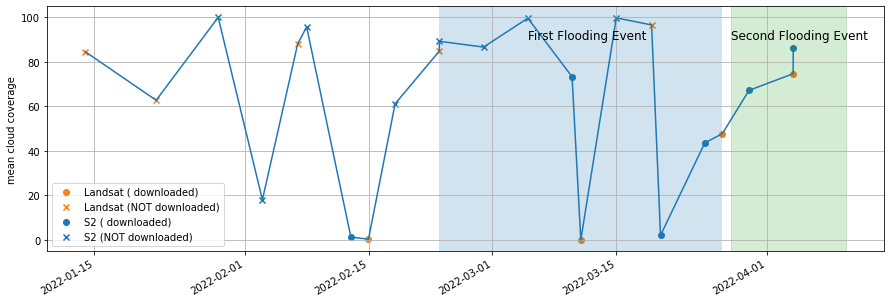

In [6]:

fig, ax = plt.subplots(1,1,figsize=(15,5))

for c,downloaded in product(["Landsat","S2"], [True, False]):
    label=f"{c} ({'' if downloaded else 'NOT'} downloaded)"
    selection_iter = (metadata.satellite == c) & (metadata.s2available == downloaded)
    color = "C0" if c =="S2" else "C1"
    marker = "o" if downloaded else "x"
    ax.scatter(x=metadata[selection_iter].datetime,y=metadata[selection_iter].cloud_probability, 
               label=label,c=color,marker=marker)

ax.legend()
metadata.plot(x="datetime",y="cloud_probability",ax=ax,legend=None)
ax.axvspan(flooding_date_first_period_start_dt, flooding_date_first_period_end_dt, alpha=0.2)
ax.axvspan(flooding_date_second_period_start_dt, flooding_date_second_period_end_dt, alpha=0.2,color="C2")

ax.text(flooding_date_first_period_start_dt + timedelta(days=10), 90, "First Flooding Event", fontsize=12)
ax.text(flooding_date_second_period_start_dt, 90, "Second Flooding Event", fontsize=12)
# for d in [flooding_date_first_period_start, flooding_date_first_period_end,flooding_date_second_period_start,flooding_date_second_period_end]:
#     plt.vlines(x=datetime.strptime(d,"%Y-%m-%d"),ymin=-1,ymax=101,colors="black",linestyles="dashed")
    
plt.ylabel("mean cloud coverage")
plt.xlabel("")
plt.grid()

### Plot downloaded Landsat and Sentinel-2 images

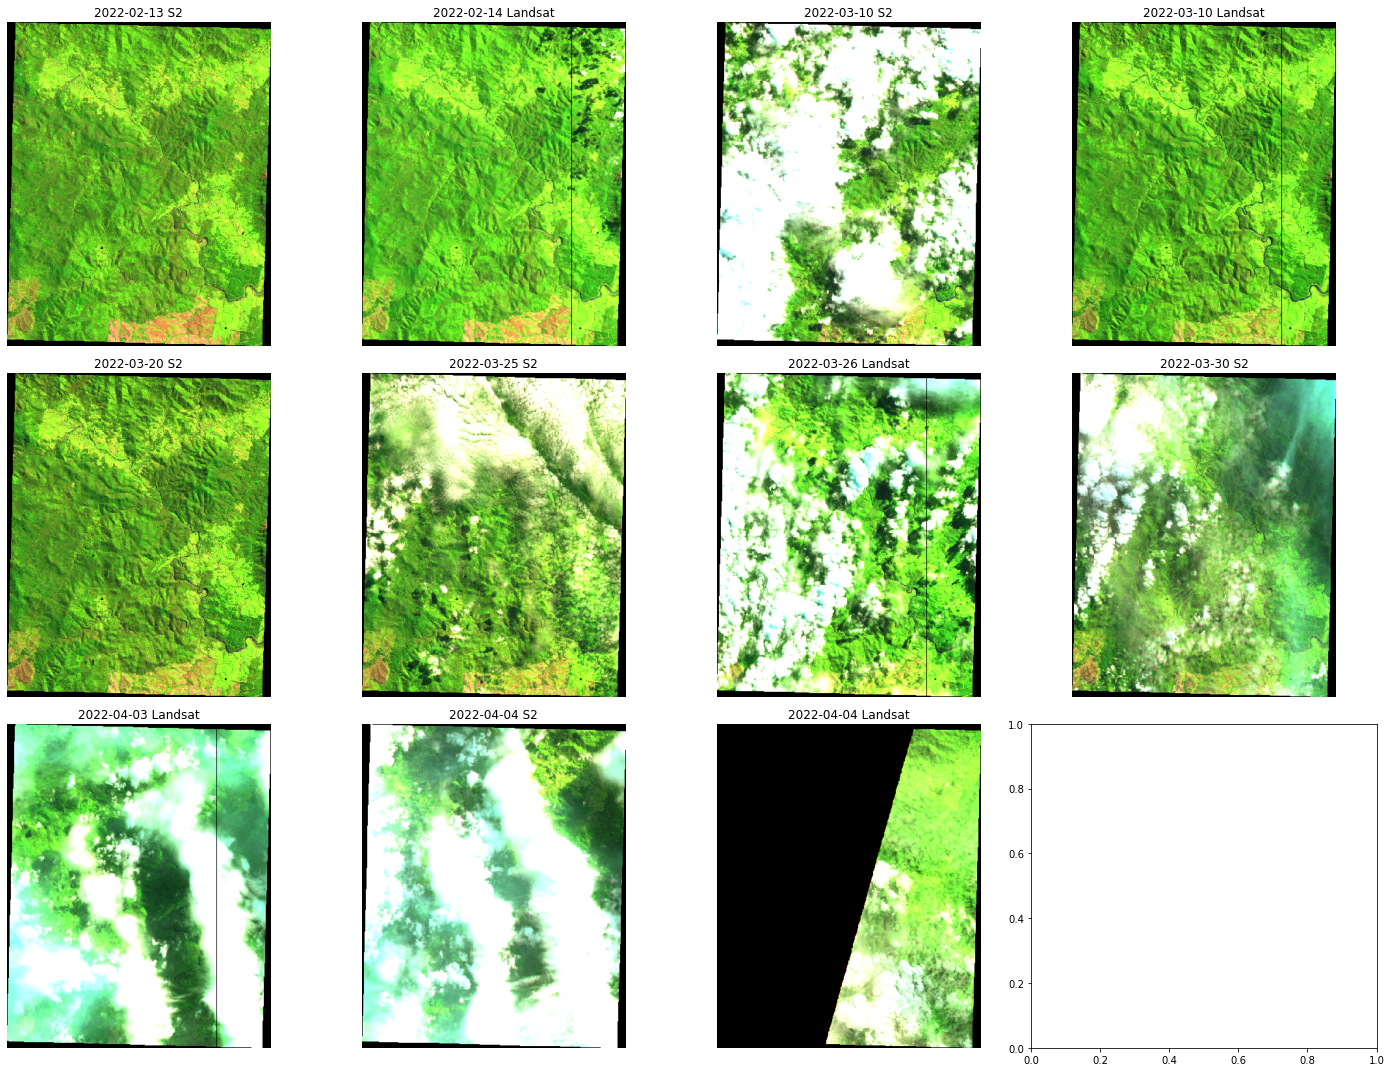

In [21]:
# fig, ax =plt.subplots(ceil(len(geojsons)/ 3),3,
#                       figsize=(20,ceil(len(geojsons)/ 3)*7.5),tight_layout=True)

fig, ax =plt.subplots(ceil(len(geojsons)/ 4),4,
                      figsize=(20,ceil(len(geojsons)/ 4)*5),tight_layout=True)

ax = ax.flatten()

for idx,g in enumerate(geojsons):
    date = os.path.splitext(os.path.basename(g))[0]
    satellite_dir = os.path.dirname(g)
    satellite = os.path.basename(satellite_dir)
    aoi_dir = os.path.dirname(os.path.dirname(satellite_dir))
    geotiff = os.path.join(aoi_dir, satellite, f"{date}.tif")
    
    plot_utils.plot_swirnirred_image(geotiff, ax=ax[idx], size_read=500, collection_name=satellite)
    ax[idx].set_title(f"{date} {satellite}")
    ax[idx].axis("off")

### Plot processed floodmaps

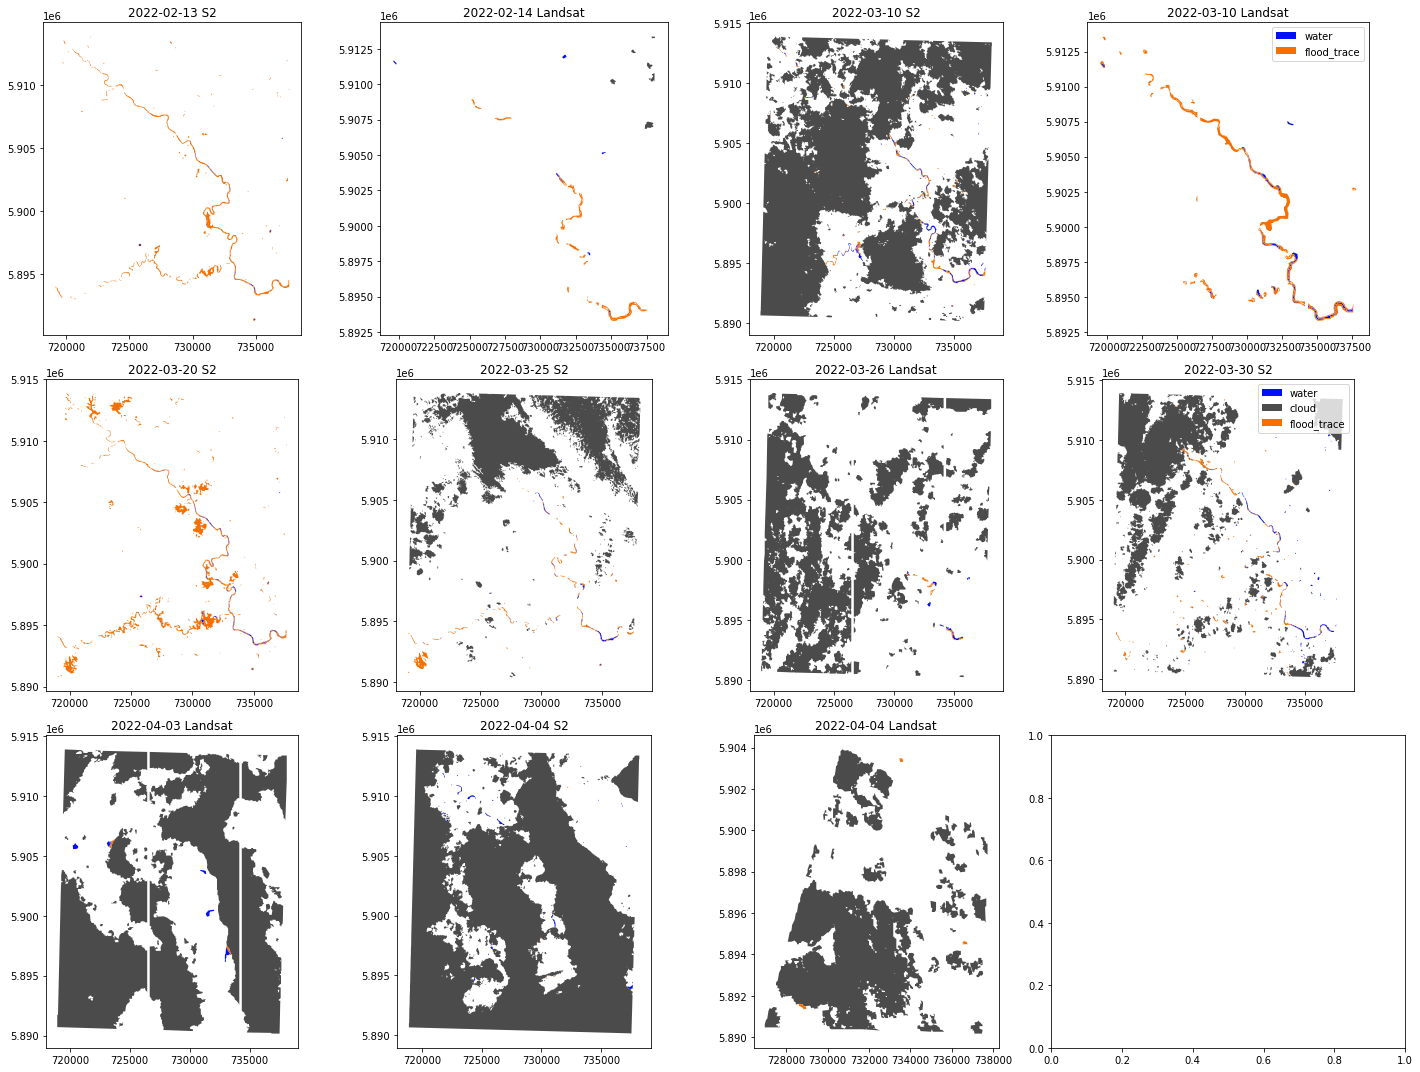

In [8]:
fig, ax =plt.subplots(ceil(len(geojsons)/ 4),4,
                      figsize=(20,ceil(len(geojsons)/ 4)*5),tight_layout=True)

ax = ax.flatten()

floodmaps = []
for idx,g in enumerate(geojsons):
    date = os.path.splitext(os.path.basename(g))[0]
    satellite = os.path.basename(os.path.dirname(g))
    floodmap = utils.read_geojson_from_gcp(g)
    floodmaps.append(floodmap)
    plot_utils.plot_floodmap(floodmap, ax=ax[idx],legend=(idx%4)==3)
    ax[idx].set_title(f"{date} {satellite}")

## Step 2: Get the water content before the flooding

In [9]:
from ml4floods.models import postprocess

floodmaps_pre = [g for g in geojsons if os.path.splitext(os.path.basename(g))[0] < flooding_date_pre]
print(f"Floodmaps to process before the flooding: {[os.path.basename(g)[0] for g in floodmaps_pre]}")
data_pre = postprocess.get_floodmap_pre(floodmaps_pre,verbose=True)
data_pre

Floodmaps to process before the flooding: ['2', '2']
All area is covered in idx 1. Area missing empty: True Geom type: Polygon


,class,geometry
0,water,"POLYGON ((725900.000 5897340.000, 725900.000 5..."
1,water,"POLYGON ((732090.000 5898660.000, 732060.000 5..."
2,water,"POLYGON ((731180.000 5898840.000, 731180.000 5..."
3,water,"POLYGON ((731160.000 5899320.000, 731160.000 5..."
4,water,"POLYGON ((731120.000 5899340.000, 731100.000 5..."
5,water,"POLYGON ((731700.000 5899950.000, 731680.000 5..."
6,water,"POLYGON ((731920.000 5900440.000, 731940.000 5..."
7,water,"POLYGON ((732900.000 5900850.000, 732900.000 5..."
8,water,"POLYGON ((732760.000 5901360.000, 732780.000 5..."
9,water,"POLYGON ((732540.000 5902240.000, 732540.000 5..."


<AxesSubplot:>

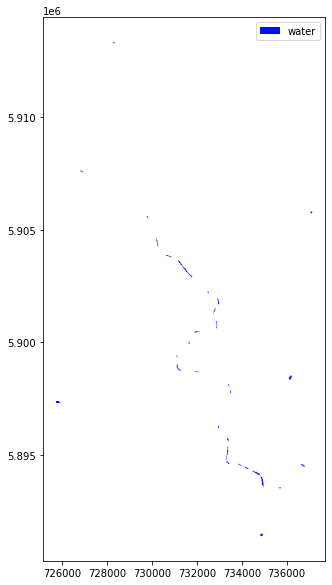

In [10]:
plot_utils.plot_floodmap(data_pre)

## Step 3: Get the water content after the first flooding event

In [11]:
floodmaps_post_first_list = [g for g in geojsons if (os.path.splitext(os.path.basename(g))[0] >= flooding_date_first_period_start) and (os.path.splitext(os.path.basename(g))[0] < flooding_date_first_period_end)]
floodmaps_post_first_list

['gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/S2/2022-03-10.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/Landsat/2022-03-10.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/S2/2022-03-20.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/S2/2022-03-25.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/Landsat/2022-03-26.geojson']

In [12]:
%%time

data_post_first_period = postprocess.get_floodmap_post(floodmaps_post_first_list,verbose=True)
data_post_first_period

All area is covered in idx 3. Area missing empty: True Geom type: Polygon
CPU times: user 961 ms, sys: 4.32 ms, total: 965 ms
Wall time: 1.73 s


,class,geometry
0,flood_trace,"POLYGON ((719008.176 5894078.637, 719039.659 5..."
1,flood_trace,"POLYGON ((725340.000 5895680.000, 725360.000 5..."
2,flood_trace,"POLYGON ((725780.000 5895680.000, 725760.000 5..."
3,flood_trace,"POLYGON ((725960.000 5895960.000, 725940.000 5..."
4,flood_trace,"POLYGON ((726220.000 5895950.000, 726140.000 5..."
...,...,...
210,water,"POLYGON ((737060.000 5905750.000, 737060.000 5..."
211,water,"POLYGON ((737080.000 5906590.000, 737050.000 5..."
212,water,"POLYGON ((736760.000 5909050.000, 736720.000 5..."
213,water,"POLYGON ((736110.000 5909530.000, 736060.000 5..."


<AxesSubplot:>

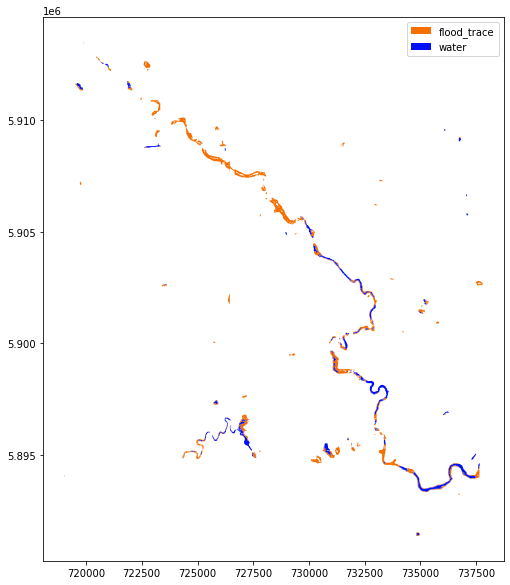

In [13]:
plot_utils.plot_floodmap(data_post_first_period)

### Plot the difference between pre and post flood observed water

In [14]:
prepost_map = postprocess.compute_flood_water(floodmap_post_data=data_post_first_period, best_pre_flood_data=data_pre)
prepost_map

,class,geometry
0,water-pre-flood,"POLYGON ((725900.000 5897340.000, 725900.000 5..."
1,water-pre-flood,"POLYGON ((732090.000 5898660.000, 732060.000 5..."
2,water-pre-flood,"POLYGON ((731180.000 5898840.000, 731180.000 5..."
3,water-pre-flood,"POLYGON ((731160.000 5899320.000, 731160.000 5..."
4,water-pre-flood,"POLYGON ((731120.000 5899340.000, 731100.000 5..."
...,...,...
281,water-post-flood,"POLYGON ((735230.000 5901840.000, 735190.000 5..."
282,water-post-flood,"POLYGON ((737080.000 5905830.000, 737100.000 5..."
283,water-post-flood,"POLYGON ((737050.000 5906580.000, 737040.000 5..."
284,water-post-flood,"POLYGON ((736720.000 5909070.000, 736720.000 5..."


<AxesSubplot:>

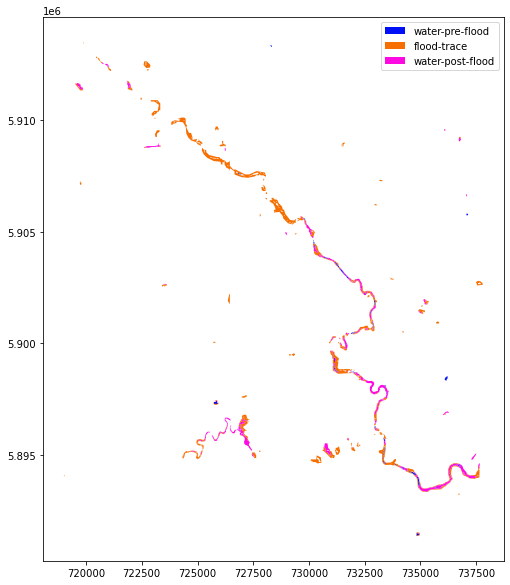

In [15]:
plot_utils.plot_floodmap(prepost_map)

## Step 4: Get the water content after the second flooding event

In [16]:
floodmaps_post_second_list = [g for g in geojsons if (os.path.splitext(os.path.basename(g))[0] >= flooding_date_second_period_start) and (os.path.splitext(os.path.basename(g))[0] < flooding_date_second_period_end)]
floodmaps_post_second_list

['gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/S2/2022-03-30.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/Landsat/2022-04-03.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/S2/2022-04-04.geojson',
 'gs://ml4cc_data_lake/0_DEV/1_Staging/operational/EMSR570/AUTOAOI144/WF2_unet_rbgiswirs_vec/Landsat/2022-04-04.geojson']

In [17]:
data_post_second_period = postprocess.get_floodmap_post(floodmaps_post_second_list,verbose=True)
data_post_second_period

,class,geometry
0,flood_trace,"POLYGON ((720180.000 5891680.000, 720140.000 5..."
1,flood_trace,"POLYGON ((724330.000 5891960.000, 724350.000 5..."
2,flood_trace,"POLYGON ((720360.000 5892010.000, 720390.000 5..."
3,flood_trace,"POLYGON ((720020.000 5891900.000, 719990.000 5..."
4,flood_trace,"POLYGON ((720400.000 5892190.000, 720380.000 5..."
...,...,...
429,cloud,"POLYGON ((728910.000 5911510.000, 728906.000 5..."
430,cloud,"POLYGON ((729150.000 5911580.000, 729127.143 5..."
431,cloud,"POLYGON ((728540.000 5912250.000, 728560.000 5..."
432,cloud,"POLYGON ((728670.000 5912840.000, 728670.000 5..."


<AxesSubplot:>

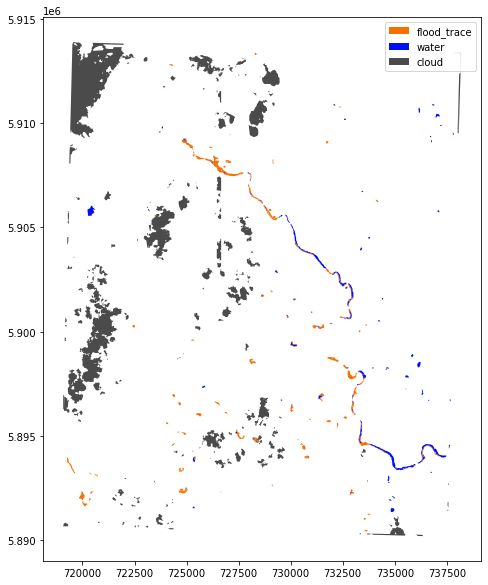

In [18]:
plot_utils.plot_floodmap(data_post_second_period)

### Compute the difference between pre and post flood observed water

In [19]:
prepost_map_second = postprocess.compute_flood_water(floodmap_post_data=data_post_second_period, best_pre_flood_data=data_pre)
prepost_map_second

,class,geometry
0,water-pre-flood,"POLYGON ((725900.000 5897340.000, 725900.000 5..."
1,water-pre-flood,"POLYGON ((732090.000 5898660.000, 732060.000 5..."
2,water-pre-flood,"POLYGON ((731180.000 5898840.000, 731180.000 5..."
3,water-pre-flood,"POLYGON ((731160.000 5899320.000, 731160.000 5..."
4,water-pre-flood,"POLYGON ((731120.000 5899340.000, 731100.000 5..."
...,...,...
462,water-post-flood,"POLYGON ((737200.000 5909870.000, 737170.000 5..."
463,water-post-flood,"POLYGON ((737010.000 5910320.000, 737000.000 5..."
464,water-post-flood,"POLYGON ((736150.000 5910630.000, 736130.000 5..."
465,water-post-flood,"POLYGON ((736820.000 5910860.000, 736790.000 5..."


<AxesSubplot:>

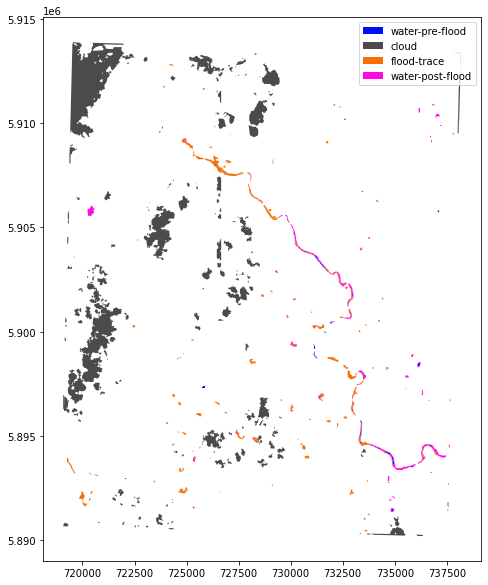

In [20]:
plot_utils.plot_floodmap(prepost_map_second)